## Step 1. 사진 준비

In [39]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os

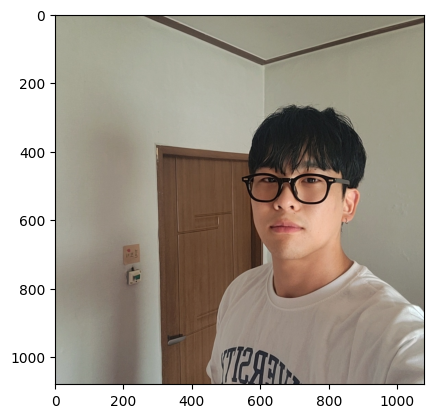

In [68]:
my_image_path='e07_mypicture.jpg'
#my_image_path='e07-Hwang2.jpg'
#my_image_path='e07-my_pictrue2.jpg'
#my_image_path = 'choie.jfif'
def image_load(my_image_path):
    my_image_path = my_image_path
    img_bgr = cv2.imread(my_image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_show = img_bgr.copy()
    return img_show,img_rgb,img_bgr
img_show,img_rgb,img_bgr = image_load(my_image_path)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

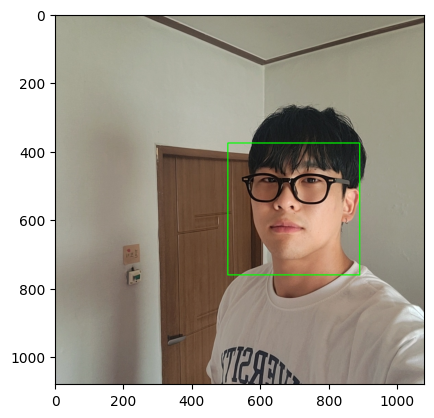

In [69]:
def face_rect(img_show,img_rgb):
    detector_hog = dlib.get_frontal_face_detector()

    dlib_rects = detector_hog(img_rgb, 1)
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
    
        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        
    return img_show_rgb, dlib_rects

img_show_rgb,dlib_rects=face_rect(img_show,img_rgb)
plt.imshow(img_show_rgb)
plt.show()

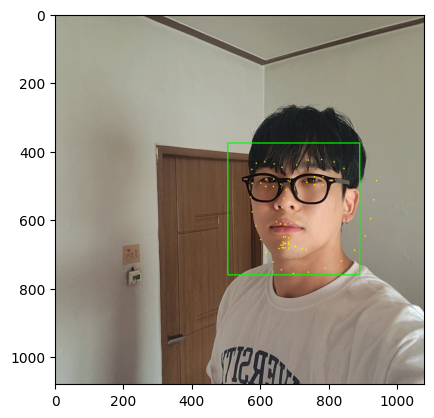

In [70]:
model_path = 'e07-shape_predictor_68_face_landmarks.dat'
def landMark(model_path,img_show,img_rgb,dlib_rects):
    landmark_predictor = dlib.shape_predictor(model_path)

    # landmark point list
    list_landmarks=[]
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # landmark 그리기
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0,255, 255), -1)
        
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    return img_show_rgb,list_landmarks

img_show_rgb,list_landmarks=landMark(model_path,img_show,img_rgb,dlib_rects)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [71]:
def nose_position(dlib_rects,list_landmarks):
    # 코 위치
    for dlib, landmark in zip(dlib_rects, list_landmarks):
        print(landmark[30])
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib.width()
    return x,y,w,h
x,y,w,h = nose_position(dlib_rects,list_landmarks)
print(f'(x,y) : ({x},{y})')
print(f'(w,h) : ({w},{h})')

(662, 565)
(x,y) : (662,565)
(w,h) : (386,386)


In [72]:
# 스티커 불러오기
sticker_path = 'e07_cat-whiskers.png'
def stiker_load(sticker_path,w,h,i=1,j=1):
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (round(w*i),round(h/j)))
    return img_sticker
img_sticker = stiker_load(sticker_path,w,h,i=1.5,j=1)
print(img_sticker.shape)

(386, 579, 3)


In [73]:
def refined(img_sticker,w,h,i=1,j=1):
    # left-top 위치 조정
    refined_x = x - round(w*i)
    refined_y = y - round(h/j)
    
    # 스티커가 원본이미지를 넘어갈 경우
    if refined_x < 0:
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:,:]
        refined_y = 0
    if refined_x+img_sticker.shape[1] >= img_bgr.shape[1]:
        img_sticker = img_sticker[:,:(img_sticker.shape[1]-(refined_x+img_sticker.shape[1]-img_bgr.shape[1]))]
    if refined_y+img_sticker.shape[0] >= img_bgr.shape[0]:
        img_sticker = img_sticker[:(img_sticker.shape[0]-(refined_x+img_sticker.shape[0]-img_bgr.shape[0])),:]
    return refined_x,refined_y,img_sticker

refined_x,refined_y,img_sticker=refined(img_sticker,w,h,i=0.75,j=2)
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (372,372)


## Step 4. 스티커 적용하기

In [74]:
def fill_data(img_show,refined_x,refined_y,img_sticker):
    # 스티커의 흰색 부분 원본데이터로 채우기
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,
                                                                                                        sticker_area,img_sticker).astype(np.uint8)
    return img_show
img_show=fill_data(img_show,refined_x,refined_y,img_sticker)

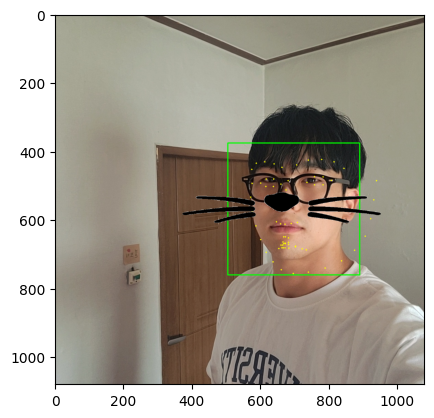

In [75]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

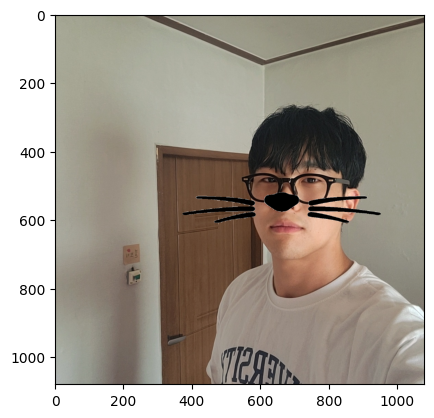

In [76]:
# rect,landmark 지우기
def del_lr(img_bgr,refined_x,refined_y,img_sticker):    
    sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    return img_bgr

img_bgr=del_lr(img_bgr,refined_x,refined_y,img_sticker)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 스티커 사진을 덮어 씌운 이미지가 나오게 된다.
plt.show()

## Step 5. 문제점 찾아보기

#### (1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

##### (2) 문제점


- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

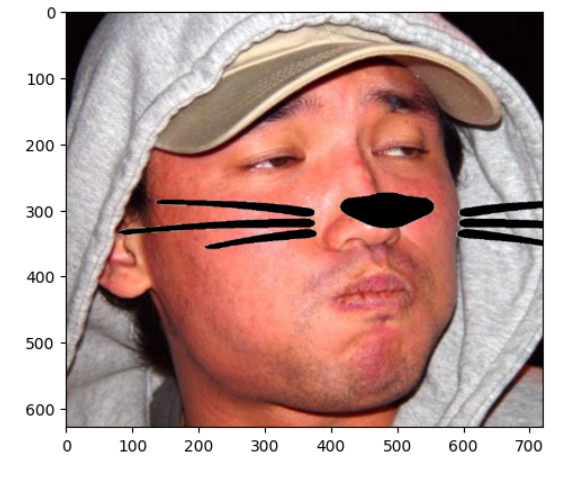

각도에 따라 얼굴을 오른쪽으로 돌릴 시 코 중심도 오른쪽으로 가게되어 스티커가 오른쪽으로 치우쳐 보이게 된다.

적당한 거리에서 찍은 사진이라면 캐릭터 사진을 쪼금 키워서 자연스럽게 만들 수 있지만, 얼굴만 크게 나온 사진 같은 경우 크기로 해결하기가 쪼끔 애매하다. 그래서 3차원 공간 컴퓨터 안쪽으로 고개를 돌리듯이 캐릭터 사진이 돌아가게 한다거나, 얼굴 각도에 따라 미세하게 x,y위치를 옮겨주거나, 코와 수염을 분리해서 따로 붙여줘야할 것 같다.

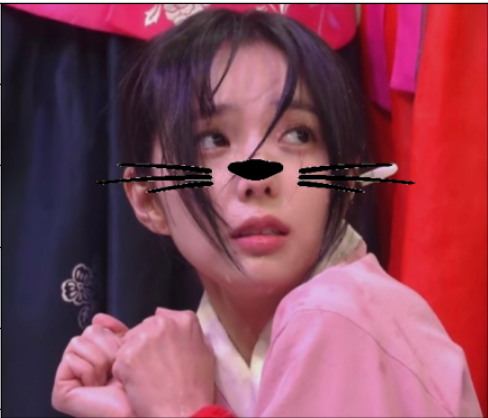

이렇게 고개를 살짝 올릴때도 캐릭터 사진을 살짝 내려준다거나 해서 어울리게 만들어 주어야할 것 같다.

따라서 사람 얼굴 사진 각도에 따라 파라미터를 넣어주어 상,하,좌,우로 각도 몇도일 때 반대 쪽으로 각도의 몇배씩 곱해주어 스티커의 위치를 조정해주는 작업이 필요함.

- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

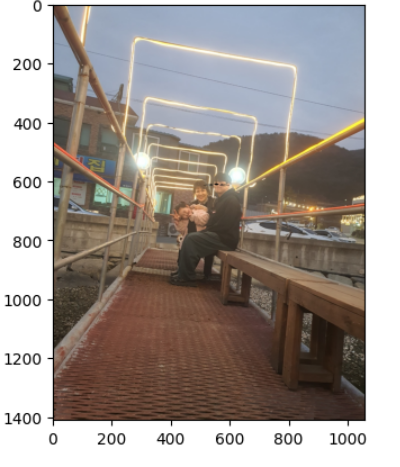

너무 멀리서 촬영할 경우 원근법에 의해 얼굴 면적도 상당히 줄어든다. 따라서 스티커 사진을 넣어도 티가 안나요. 

적당한 거리가 중요한 것 같다.

누울 시엔 스티커사진을 그만큼 돌려야한다.

- 실행 속도가 중요할까요?

어플리케이션 같은 경우 고객에게 서비스를 할 용도로 만들어지는 경우가 많다.

카메라 스티커앱 또한 인식이 느릴 경우 고객이 답답할 수가 있다. 빠르면 빠를 수록 좋은게 로딩속도라고 생각합니다.

.

- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

뜬금없이 수염을 이마에 붙인다면 의아할 것이다. 사회통념상 정해진 자리에 본인이 의도한 위치에 스티커가 있어야 이번 어플리케이션을 만드는 취지에 맞을 것 같다.